In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import cmocean.cm as cmo
plt.rcParams['figure.facecolor'] = 'white'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d

In [2]:
path = "../data_for_plots/" 

In [10]:
THETAsurf = xr.open_mfdataset(path + "THETA_0250-09-03_surf.nc")
THETAyz = xr.open_mfdataset(path + "THETA_0250-09-03_yz.nc")
THETAxz = xr.open_mfdataset(path + "THETA_0250-09-03_xz.nc")
SIarea = xr.open_mfdataset(path + "SIarea_0250-09-03.nc")
MOC_res_z = xr.open_mfdataset(path + "MOC_res_z_0201-01-01_0300-12-30.nc")

In [11]:
y1 = 0.01e6; y2 = 3.2e6; x1 = 0.0e6; x2 = 2.4e6; 
maxice = 1.0; minice = 0.0; zmax = 4000; maxT = 15.0; minT = -2

In [16]:
XC = THETAsurf.XC.sel(XC=slice(x1, x2)).compute()
YC = THETAsurf.YC.sel(YC=slice(y1, y2)).compute()
YG = MOC_res_z.YG.sel(YG=slice(y1, y2)).compute()
Z = THETAyz.Z.sel(Z=slice(0, -zmax)).compute()
THETASURF = THETAsurf.THETA.sel(XC=slice(x1, x2), YC=slice(y1, y2)).compute()
THETAYZ = THETAyz.THETA.where(THETAyz.THETA != 0).sel(YC=slice(y1, y2), Z=slice(0, -zmax)).compute()
THETAXZ = THETAxz.THETA.where(THETAxz.THETA != 0).sel(XC=slice(x1, x2), Z=slice(0, -zmax)).compute()
MOCyz = -MOC_res_z.MOC_res_z.where(MOC_res_z.MOC_res_z != 0).sel(YG=slice(y1, y2), Z=slice(0, -zmax)).compute()
ICEsurf = SIarea.SIarea.where(SIarea.SIarea > 0.15).sel(XC=slice(x1, x2), YC=slice(y1, y2)).compute()

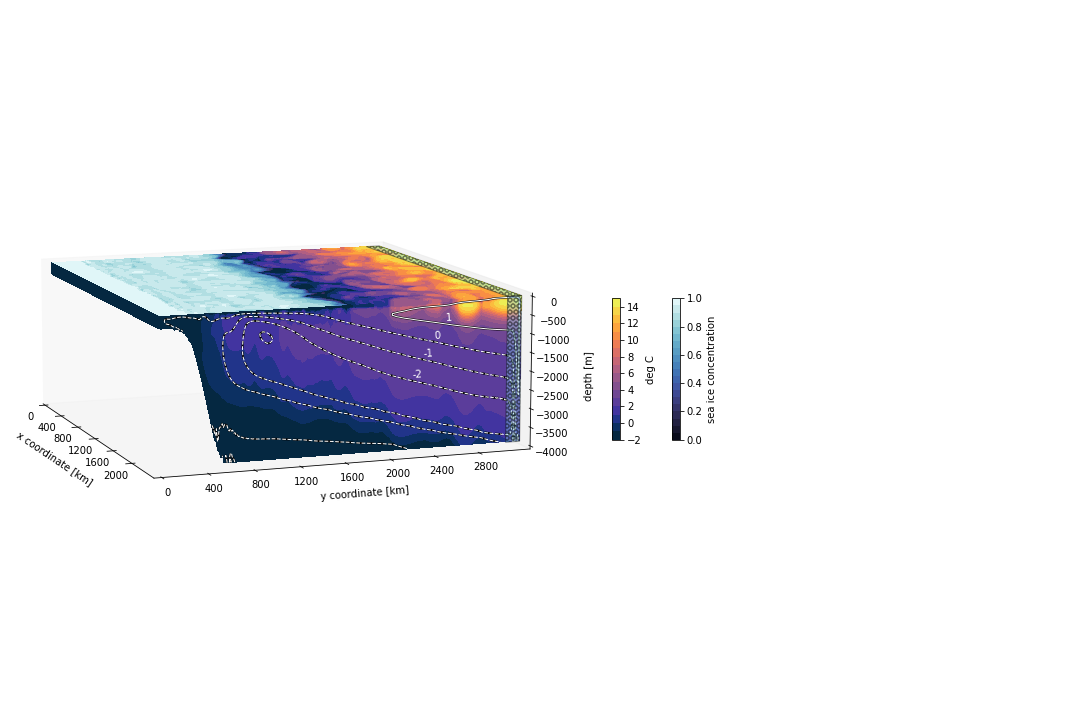

In [17]:
fig= plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d', computed_zorder=False)
cax1 = ax.inset_axes([1.13, 0.35, 0.014, 0.26])
cax2 = ax.inset_axes([1.24, 0.35, 0.014, 0.26])
# set angles of view (up-down, left-right)
ax.view_init(10, 340)

# set levels and min/max values for different variables
THETAlevs = np.linspace(minT, maxT, 18)
THETAcmap = cmo.thermal

ICElevs = np.linspace(0, 1.0, 21)
ICEcmap = cmo.ice

MOClevs = np.arange(-4.5e6, 4.6e6, 1.0e6)

# plot the surface
surf1 = ax.contourf(XC, YC, THETASURF, zdir='z', offset=0.0, cmap=THETAcmap, levels=THETAlevs, zorder=1)
surf2 = ax.contourf(XC, YC, ICEsurf, zdir='z', offset=0.0, cmap=ICEcmap, levels=ICElevs, zorder=2)

# plot the y-z plane
yz1 = ax.contourf(THETAYZ, YC, Z, zdir='x', offset=x2, cmap=THETAcmap, levels=THETAlevs, zorder=3)
# add some contours
yz2 = ax.contour(MOCyz.T, YG, Z, zdir='x', offset=x2, colors='k', linewidths=2, levels=MOClevs, zorder=4)
yz2 = ax.contour(MOCyz.T, YG, Z, zdir='x', offset=x2, colors='w', linewidths=1, levels=MOClevs, zorder=5)
# labeling of contours only works manually... have to be really careful not to put the labels in the wrong place
clabels = [-2, -1, 0, 1]
ylocs = [2.2e6, 2.3e6, 2.4e6, 2.5e6]
zlocs = [-2000, -1450, -1000, -550]
for clabel, y, z in zip(clabels, ylocs, zlocs):
    ax.text(x2+1e4, y, z, clabel, 'y', fontsize=10, zorder=200, color="w")

# plot the x-z plane
xz1 = ax.contourf(XC, THETAXZ.T, Z, zdir='y', offset=y1, cmap=THETAcmap, levels=THETAlevs, zorder=5)

c1 = plt.colorbar(yz1, pad=0.1, shrink=0.2, label='deg C', cax=cax1)
c2 = plt.colorbar(surf2, pad=0.1, shrink=0.2, label='sea ice concentration', cax=cax2, ticks=np.arange(0, 1.1, 0.2))

ax.set_xlim3d(x1, x2)
ax.set_ylim3d(y1, y2)
ax.set_zlim3d(-zmax, 0)
ax.grid(None)
ax.set_box_aspect((1, 1, 0.4))
plt.xticks(np.arange(x1, x2, 0.4e6), np.arange(x1 / 1e3, x2 / 1e3, 400).astype(int));
ax.set_xlabel('x coordinate [km]', labelpad=10)
plt.yticks(np.arange(y1-0.01e6, y2, 0.4e6), np.arange((y1-0.01e6) / 1e3, y2 / 1e3, 400).astype(int));
ax.set_ylabel('y coordinate [km]', labelpad=15)
ax.set_zlabel('depth [m]', labelpad=10)

sponge_yz = Rectangle((3.07e6, -3900), 0.13e6, 3900, alpha=0.4, facecolor="skyblue", hatch="OO", edgecolor="k", zorder=6)
sponge_xy = Rectangle((0, 3.07e6), 2.4e6, 0.13e6, alpha=0.4, facecolor="skyblue", hatch="OO", edgecolor="k", zorder=6)
ax.add_patch(sponge_yz)
ax.add_patch(sponge_xy)
art3d.pathpatch_2d_to_3d(sponge_yz, z=x2, zdir="x")
art3d.pathpatch_2d_to_3d(sponge_xy, z=0, zdir="z")

plt.subplots_adjust(left=-0.5, right=1.0)

plt.savefig("fig01-3D_ice_temp_moc.png", dpi=300)